# Parameter Optimization for HOG-SVR Model

This notebook explores and optimizes various parameters for our fiber orientation prediction model:

1. HOG Parameters:
   - Number of orientations
   - Grid cell sizes
   - Cell normalization

2. SVR Hyperparameters:
   - Kernel selection
   - C (regularization)
   - Gamma (RBF kernel parameter)

3. Dimensionality Reduction:
   - PCA components optimization
   - Feature importance analysis

The goal is to find the optimal parameter combinations for the best model performance.

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error

# Add src directory to Python path for imports
sys.path.append(os.path.abspath('../../src'))

# Import from our package
from fiber_predictor.svr_hog.feature_extraction import HogFeatureExtractor
from fiber_predictor.svr_hog.data_processing import HogDataset
from fiber_predictor.svr_hog.models import FiberPredictor

## 1. Data Loading

In [4]:
# Load a small subset of data for quick parameter testing
bio_file_dir = "../../images/bio/"
bio_csv_dir = "../../images/bio/labels.csv"

# Initial dataset with default parameters
initial_dataset = HogDataset(
    labels_path=bio_csv_dir,
    file_dir=bio_file_dir,
    grid_quotient=4,
    orientations=8,
    augment_whole_dataset=False
)

# Extract features and labels
def extract_features_labels(dataset):
    feature_matrix = []
    labels = []
    for idx in range(len(dataset)):
        _, features_tensor, angle = dataset[idx]
        feature_matrix.append(features_tensor.numpy())
        labels.append(angle)
    return np.array(feature_matrix), np.array(labels)

X, y = extract_features_labels(initial_dataset)
print(f"Dataset size: {len(y)} samples")

Dataset size: 673 samples


## 2. HOG Parameter Optimization

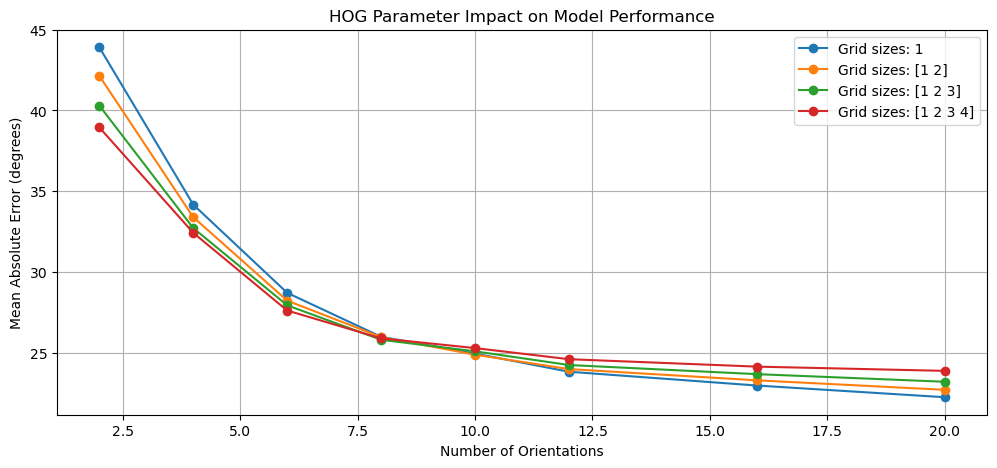


Top 5 Parameter Combinations:


,orientations,grid_size,mae,feature_dim
28,20,1,22.237106,20
29,20,"[1, 2]",22.696139,100
24,16,1,22.961359,16
30,20,"[1, 2, 3]",23.195912,280
25,16,"[1, 2]",23.284069,80


In [5]:
def evaluate_hog_params(images, labels, orientations_list, grid_sizes_list):
    """Evaluate different HOG parameter combinations"""
    results = []
    
    for orientations in orientations_list:
        for grid_size in grid_sizes_list:
            # print(f"Testing orientations={orientations}, grid_size={grid_size}")
            
            # Extract features with current parameters
            hog_extractor = HogFeatureExtractor(grid_size, orientations)
            features = [hog_extractor(img) for img in images]
            
            # Basic model evaluation
            model = FiberPredictor()
            scores = cross_val_score(model.model, features, labels, 
                                    cv=5, scoring='neg_mean_absolute_error')
            mae = -np.mean(scores)
            
            results.append({
                'orientations': orientations,
                'grid_size': grid_size,
                'mae': mae,
                'feature_dim': len(features[0])
            })
    
    return pd.DataFrame(results)

# Test different parameter combinations
orientations_list = [2, 4, 6, 8, 10, 12, 16, 20]
grid_sizes_list = [1, np.arange(1, 3), np.arange(1, 4), np.arange(1, 5)]

# Get raw images for testing
images = [initial_dataset.load_image(os.path.join(bio_file_dir, f)) 
          for f in initial_dataset.filenames]

results_df = evaluate_hog_params(images, y, orientations_list, grid_sizes_list)

# Plot results
plt.figure(figsize=(12, 5))
for grid_size in grid_sizes_list:
    mask = results_df['grid_size'].apply(lambda x: np.array_equal(x, grid_size))
    plt.plot(results_df[mask]['orientations'], 
             results_df[mask]['mae'], 
             'o-', 
             label=f'Grid sizes: {grid_size}')

plt.xlabel('Number of Orientations')
plt.ylabel('Mean Absolute Error (degrees)')
plt.title('HOG Parameter Impact on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

# Show best combinations
print("\nTop 5 Parameter Combinations:")
display(results_df.sort_values('mae').head())

## 3. SVR Hyperparameter Optimization

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters:
{'regressor__C': 10, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}
Best MAE: 18.80°


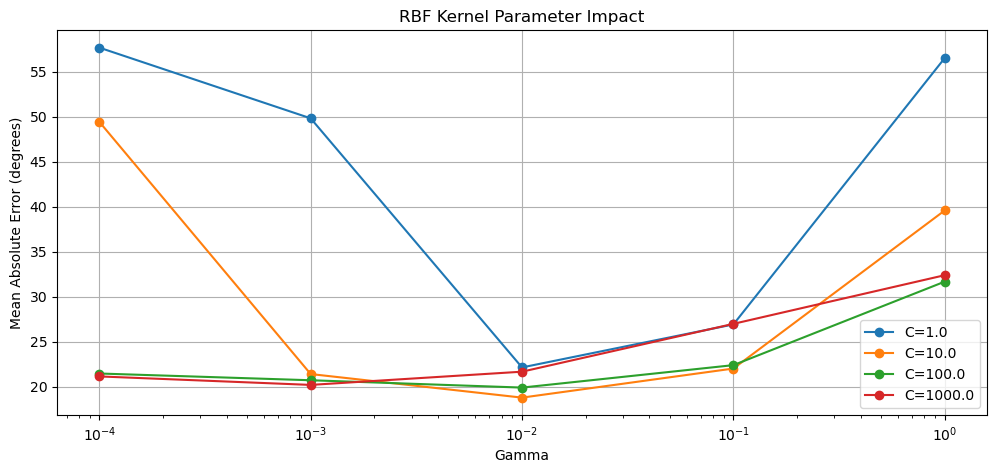

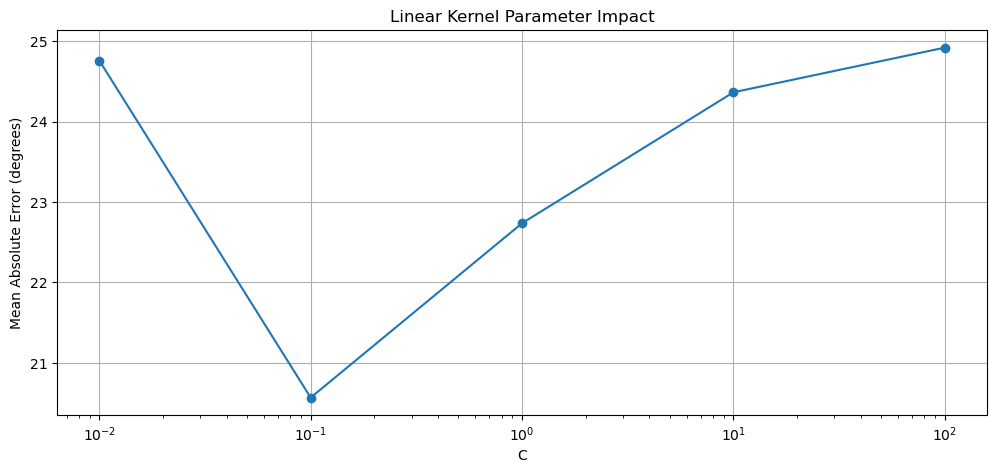

In [6]:
# Use the best HOG parameters from above
best_hog = HogFeatureExtractor(
    grid_quotient=results_df.sort_values('mae').iloc[0]['grid_size'],
    orientations=results_df.sort_values('mae').iloc[0]['orientations']
)

# Extract features with best HOG parameters
X_best = np.array([best_hog(img) for img in images])

# Define parameter grid for SVR
param_grid = [
    {'regressor__kernel': ['linear'], 
     'regressor__C': [0.01, 0.1, 1, 10, 100]},
    {'regressor__kernel': ['rbf'], 
     'regressor__C': [1, 10, 100, 1000],
     'regressor__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
]

# Create base model
model = FiberPredictor()

# Perform grid search
grid_search = GridSearchCV(
    model.model, 
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_best, y)

print("\nBest parameters:")
print(grid_search.best_params_)
print(f"Best MAE: {-grid_search.best_score_:.2f}°")

# Plot parameter impact
results = pd.DataFrame(grid_search.cv_results_)

# Plot for the RBF kernel
rbf_results = results[results['param_regressor__kernel'] == 'rbf']

plt.figure(figsize=(12, 5))
for C in np.unique(rbf_results['param_regressor__C']):
    subset = rbf_results[rbf_results['param_regressor__C'] == C]
    plt.semilogx(
        subset['param_regressor__gamma'],
        -subset['mean_test_score'],
        'o-',
        label=f'C={C}'
    )

plt.xlabel('Gamma')
plt.ylabel('Mean Absolute Error (degrees)')
plt.title('RBF Kernel Parameter Impact')
plt.legend()
plt.grid(True)
plt.show()

# Plot for the Linear kernel
linear_results = results[results['param_regressor__kernel'] == 'linear']

plt.figure(figsize=(12, 5))
plt.semilogx(
    linear_results['param_regressor__C'],
    -linear_results['mean_test_score'],
    'o-'
)
plt.xlabel('C')
plt.ylabel('Mean Absolute Error (degrees)')
plt.title('Linear Kernel Parameter Impact')
plt.grid(True)
plt.show()


## 4. PCA Components Analysis

Testing PCA ratio: 0.7
Testing PCA ratio: 0.8
Testing PCA ratio: 0.85
Testing PCA ratio: 0.9
Testing PCA ratio: 0.95
Testing PCA ratio: 0.99


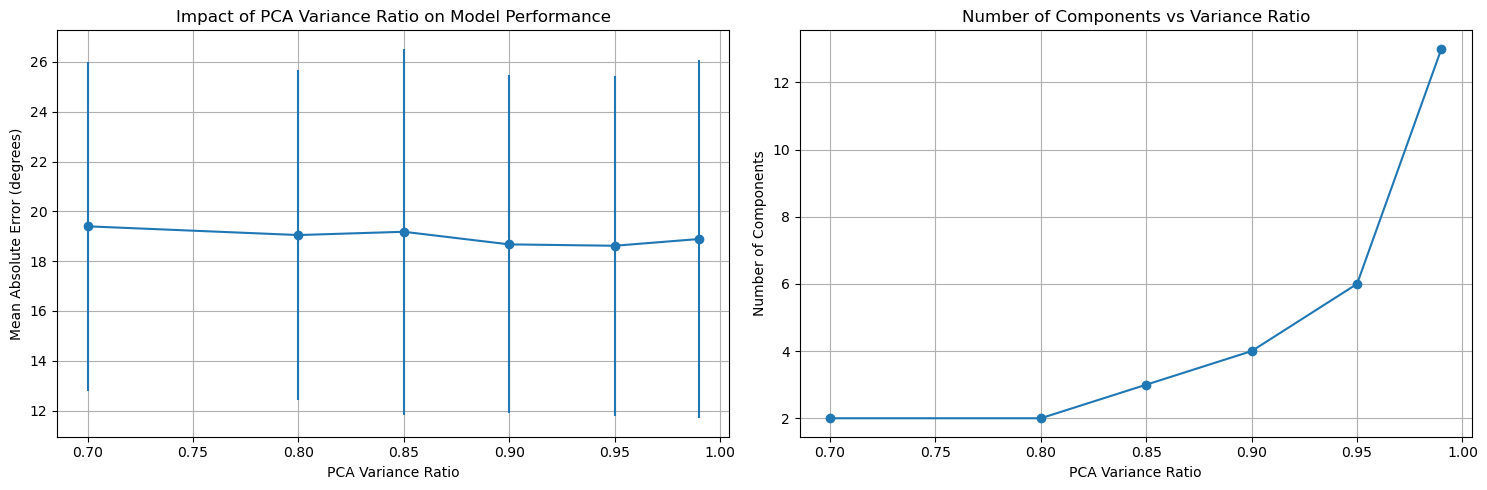


PCA Analysis Results:


,variance_ratio,n_components,mae,std
0,0.70,2,19.399287,6.619781
1,0.80,2,19.048725,6.636625
2,0.85,3,19.180620,7.349056
3,0.90,4,18.674287,6.792243
4,0.95,6,18.618645,6.833425
5,0.99,13,18.889280,7.199228


In [7]:
# Test different PCA variance ratios
variance_ratios = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
pca_results = []

for ratio in variance_ratios:
    print(f"Testing PCA ratio: {ratio}")
    model = FiberPredictor(
        pca_params={'n_components': ratio},
        regressor_params={
            'kernel': grid_search.best_params_['regressor__kernel'],
            'C': grid_search.best_params_['regressor__C'],
            'gamma': grid_search.best_params_['regressor__gamma']
        }
    )
    
    scores = cross_val_score(model.model, X_best, y, 
                            cv=5, scoring='neg_mean_absolute_error')
    
    # Fit once to get number of components
    model.fit(X_best, y)
    n_components = model.model.named_steps['pca'].n_components_
    
    pca_results.append({
        'variance_ratio': ratio,
        'n_components': n_components,
        'mae': -np.mean(scores),
        'std': np.std(scores)
    })

pca_df = pd.DataFrame(pca_results)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.errorbar(pca_df['variance_ratio'], 
            pca_df['mae'], 
            yerr=pca_df['std'], 
            fmt='o-')
ax1.set_xlabel('PCA Variance Ratio')
ax1.set_ylabel('Mean Absolute Error (degrees)')
ax1.set_title('Impact of PCA Variance Ratio on Model Performance')
ax1.grid(True)

ax2.plot(pca_df['variance_ratio'], 
         pca_df['n_components'], 
         'o-')
ax2.set_xlabel('PCA Variance Ratio')
ax2.set_ylabel('Number of Components')
ax2.set_title('Number of Components vs Variance Ratio')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nPCA Analysis Results:")
display(pca_df)